In [22]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

Read in cleaned data from csv file

In [4]:
posts_df = pd.read_csv('data/clean_posts.csv')
posts_df.head()

,subreddit,selftext,title,author,created_utc,created_date,class
0,AskCulinary,I’m desperate to get baking again since my las...,Looking for a new oven for my apartment.,crazygoatperson,1609271445,2020-12-29 19:50:45,1
1,AskCulinary,Making a pot of arroz con gandules/rice with p...,How to repurpose shredded chicken so it doesn’...,xbisoubisoux,1609271171,2020-12-29 19:46:11,1
2,AskCulinary,So Im usually the chef of the house ( ) and ha...,Whole roast guinea fowl,PastyManFish,1609271101,2020-12-29 19:45:01,1
3,AskCulinary,Yogurt brands only mention names of the bacter...,Is there a way I can find out what strain of b...,relativefluffy,1609270801,2020-12-29 19:40:01,1
4,AskCulinary,I mainly want to try infusing the honey with d...,I have 3kg of honey from a local beekeeper - w...,OstoValley,1609270211,2020-12-29 19:30:11,1


Set up X, y and split the data into train and test

In [7]:
X = posts_df['selftext']
y = posts_df['class']
y.value_counts(normalize=True)

1    0.547844
0    0.452156
Name: class, dtype: float64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=21)

#### Create pipeline with 
* CountVectorizer (transformer)
* Multinomial Naive Bayes (estimator)

Code borrowed heavily from class lecture 5.04

In [9]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [51]:
# add stop words that might be measurements for recipes, and distance for running (km)
# hat tip to for adding custom stop words : https://stackoverflow.com/a/24386751/732396

# the most common words in the running subreddit were, not surprisingly, run and running, so take
# those out

# After our EDA, add 'just' and 'like', which were the two most common words
added_stop_words = ['oz', 'cups', 'km', 'run', 'running', 'just', 'like']
more_stop_words = text.ENGLISH_STOP_WORDS.union(added_stop_words)

In [52]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words' : [more_stop_words]
}

# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5, verbose=1)

# Fit GridSearch to training data.
gs.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   14.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                                         'always',

In [53]:
# What's the best score?
print(gs.best_score_)

0.9843106376408832


In [54]:
# Creating a list to avoid printing the entire list of stop words
print(list(gs.best_params_.keys())[0:4])
print(list(gs.best_params_.values())[0:4])

['cvec__max_df', 'cvec__max_features', 'cvec__min_df', 'cvec__ngram_range']
[0.9, 2000, 3, (1, 2)]


In [55]:
# Score model on training set.
gs.score(X_train, y_train)

0.9858712715855573

In [56]:
# Score model on testing set.
gs.score(X_test, y_test)

0.9777070063694268

In [57]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

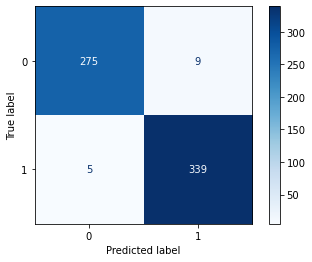

In [58]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

#### Create model with TfidfVectorizer and MultinomialNB

Code borrowed heavily from class lecture 5.04

In [59]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [60]:
pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [more_stop_words],
    'tvec__ngram_range': [(1,1), (1,2)]
}

# Instantiate GridSearchCV.
gs_tvec = GridSearchCV(pipe_tvec,
                    param_grid = pipe_tvec_params, 
                    cv=5,
                    verbose=1) 

In [61]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    3.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                                         'always', 'am',
                                                         'among', 'amongst',
                   

In [62]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.9937205651491365

In [63]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.982484076433121

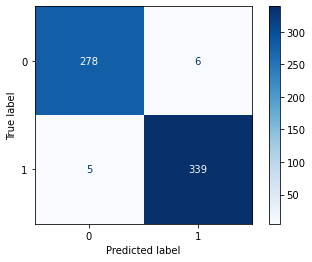

In [64]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d');